In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import optuna
import optuna.visualization as vis
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, confusion_matrix, 
                            roc_curve, precision_recall_curve, 
                            average_precision_score)
from mrmr import mrmr_classif

# Import Data

In [2]:
# Load the data
file_path = "features-Master.csv"
data = pd.read_csv(file_path)

# Shuffle the data
shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True)
data_shuffled = shuffled.iloc[:, 4:]
labels_shuffled = shuffled["Comfort Score"]

print("Number of Comfort Score == 3:", (labels_shuffled == 3).sum())

# Create binary labels (1,2 = 0; 4,5 = 1; exclude 3 for clearer separation)
binary_labels = labels_shuffled.apply(lambda x: 0 if x <= 2 else (1 if x >=4 else np.nan))
binary_data = data_shuffled[~binary_labels.isna()]
binary_labels = binary_labels[~binary_labels.isna()] 

Number of Comfort Score == 3: 100


# Train/Test Split

In [3]:
# For binary classification
X_train, X_test, y_train, y_test = train_test_split(
    binary_data,
    binary_labels,
    test_size=0.2,
    stratify=binary_labels,
    random_state=42
)

# MRMR Wrapper

In [4]:
class MRMRTransformer:
    def __init__(self, k_features):
        self.k_features = k_features
        self.selected_features = None
        self.column_names = None
    
    def fit(self, X, y):
        # Convert to DataFrame if not already
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        
        # Reset indices to avoid alignment issues
        X = X.reset_index(drop=True)
        y = pd.Series(y).reset_index(drop=True)
        
        self.column_names = X.columns.tolist()
        try:
            self.selected_features = mrmr_classif(X, y, K=self.k_features)
            print("Got MRMR features")
        except:
            # Fallback to random features if MRMR fails
            self.selected_features = np.random.choice(X.columns, size=min(self.k_features, len(X.columns)), replace=False)
            print("MRMR failed, selected random features instead.")
        return self
    
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.column_names)
        return X[self.selected_features]

# Optimize Feature Selection and XGBoost Parameters

In [5]:
X = X_train.copy()
y = y_train.copy()

def binary_classification_objective(trial):
    # Feature selection, only optimizing method and number of features (no hyperparameters of the methods)
    fs_method = trial.suggest_categorical('feature_selection', ['MRMR', 'RFE', 'None'])
    
    if fs_method != 'None':
        k_features = trial.suggest_int('k_features', 5, 105, step = 10) # Only allow a maximum of 105 features to be selected, with a step of 10, to go up to all features: X.shape[1]
        if fs_method == 'RFE':
            estimator = RandomForestClassifier()
            selector = RFE(estimator, n_features_to_select=k_features)
        else: #MRMR
            selector = MRMRTransformer(k_features=k_features) #https://feature-engine.trainindata.com/en/1.8.x/api_doc/selection/MRMR.html#feature_engine.selection.MRMR
    else:
        selector = 'passthrough'
    
    # XGBoost hyperparameters 
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000, step = 50),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'random_state': 42,
        'eval_metric': trial.suggest_categorical('eval_metric', ['logloss', 'auc']), #https://xgboost.readthedocs.io/en/stable/parameter.html#general-parameters
        'objective': 'binary:logistic', #https://xgboost.readthedocs.io/en/stable/parameter.html#general-parameters
    }
    model = XGBClassifier(**params)
        
    # Pipeline
    pipeline = Pipeline([
        ('feature_selection', selector),
        ('model', model)
    ])

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    try:
        scores = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc', n_jobs=1)
        return np.mean(scores)
    except Exception as e:
        print(f"Error in trial: {e}")
        return -np.inf

# Run binary classification study
study = optuna.create_study(direction='maximize')
study.optimize(binary_classification_objective, n_trials=5, show_progress_bar=True)

# Print results
print("\nBinary Classification Optimization Results:")
print(f"Best ROC AUC Score: {study.best_value:.4f}")
print("Best Parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-08-29 10:48:33,144] A new study created in memory with name: no-name-6c549d42-0aa8-4f00-b1c4-8fc9a150031d


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 75/75 [00:02<00:00, 28.02it/s]


Got MRMR features


100%|██████████| 75/75 [00:02<00:00, 28.54it/s]


Got MRMR features


100%|██████████| 75/75 [00:02<00:00, 28.68it/s]


Got MRMR features


100%|██████████| 75/75 [00:02<00:00, 28.51it/s]


Got MRMR features


100%|██████████| 75/75 [00:02<00:00, 28.38it/s]


Got MRMR features
[I 2025-08-29 10:48:54,207] Trial 0 finished with value: 0.7440497773831107 and parameters: {'feature_selection': 'MRMR', 'k_features': 75, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.01047384639208144, 'subsample': 0.6821515646698622, 'colsample_bytree': 0.9231862835847191, 'gamma': 2.3639396869761726, 'reg_alpha': 8.034490746986734, 'reg_lambda': 9.005850756947375, 'eval_metric': 'logloss'}. Best is trial 0 with value: 0.7440497773831107.


100%|██████████| 95/95 [00:03<00:00, 27.30it/s]


Got MRMR features


100%|██████████| 95/95 [00:03<00:00, 27.91it/s]


Got MRMR features


100%|██████████| 95/95 [00:03<00:00, 28.82it/s]


Got MRMR features


100%|██████████| 95/95 [00:03<00:00, 29.33it/s]


Got MRMR features


100%|██████████| 95/95 [00:03<00:00, 28.76it/s]


Got MRMR features
[I 2025-08-29 10:49:14,084] Trial 1 finished with value: 0.7523667690334357 and parameters: {'feature_selection': 'MRMR', 'k_features': 95, 'n_estimators': 800, 'max_depth': 3, 'learning_rate': 0.009548597866671758, 'subsample': 0.8206619578873968, 'colsample_bytree': 0.7943886879431088, 'gamma': 1.474239143308555, 'reg_alpha': 7.012940065477881, 'reg_lambda': 4.593070234318165, 'eval_metric': 'logloss'}. Best is trial 1 with value: 0.7523667690334357.
[I 2025-08-29 10:49:19,552] Trial 2 finished with value: 0.7712232212232213 and parameters: {'feature_selection': 'None', 'n_estimators': 650, 'max_depth': 5, 'learning_rate': 0.0634639304288098, 'subsample': 0.5803180334396127, 'colsample_bytree': 0.8003586950804229, 'gamma': 4.278428954717313, 'reg_alpha': 0.049270323270651506, 'reg_lambda': 8.712773973894333, 'eval_metric': 'logloss'}. Best is trial 2 with value: 0.7712232212232213.
[I 2025-08-29 10:53:17,042] Trial 3 finished with value: 0.7898718565385232 and param

# Visualization

In [6]:
# 1. Parameter Importance Plot
fig = vis.plot_param_importances(study, target_name="ROC AUC Score")
fig.show()

# 2. Slice Plot (Best for seeing individual parameter effects)
fig = vis.plot_slice(
    study,
    params=[
        'max_depth',
        'n_estimators',
        'learning_rate',
        'k_features',
        'eval_metric'
    ],
    target_name="ROC AUC Score"
)
fig.show()

# Apply Feature Selection to Train and Test Data

In [7]:
# apply your feature selection code from before
best_fs_method = study.best_params.get('feature_selection', 'None')

if best_fs_method != 'None':
    k_features = study.best_params['k_features']
    if best_fs_method == 'RFE':
        estimator = RandomForestClassifier()
        selector = RFE(estimator)
    elif best_fs_method == 'MRMR':
        selector = MRMRTransformer(k_features=k_features)
    
    selector.fit(X, y)
    if hasattr(selector, 'get_support'):  # For RFE
        selected_features = X.columns[selector.get_support()]
    else:  # For MRMRTransformer
        selected_features = selector.selected_features
    X_best = X[selected_features]
else:
    X_best = X
    selected_features = X.columns

# Apply the same feature selection to test data
if best_fs_method != 'None':
    if best_fs_method == 'MRMR':
        X_test_final = X_test[selected_features]
    else:
        X_test_final = selector.transform(X_test)  # Use the already fitted selector
        if isinstance(X_test, pd.DataFrame):
            X_test_final = pd.DataFrame(X_test_final, columns=selected_features)
else:
    X_test_final = X_test

# Create and Fit XGBoost Model with Best Parameters

In [8]:
best_model = XGBClassifier(
    n_estimators=study.best_params['n_estimators'],
    max_depth=study.best_params['max_depth'],
    learning_rate=study.best_params['learning_rate'],
    subsample=study.best_params['subsample'],
    colsample_bytree=study.best_params['colsample_bytree'],
    gamma=study.best_params['gamma'],
    reg_alpha=study.best_params['reg_alpha'],
    reg_lambda=study.best_params['reg_lambda'],
    eval_metric=study.best_params['eval_metric'],
    objective='binary:logistic',
    random_state=42,
    use_label_encoder=False
    )

# Train on full imputed data
best_model.fit(X_best, y)
params_dict = best_model.get_params()

# Run Model & Get Outcomes


Final Model Evaluation on Test Set:
Accuracy: 0.6833
Precision: 0.6944
Recall: 0.7576
F1 Score: 0.7246
ROC AUC: 0.7520


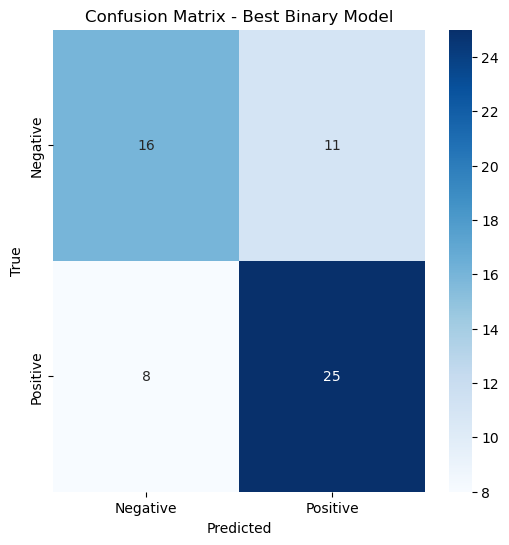

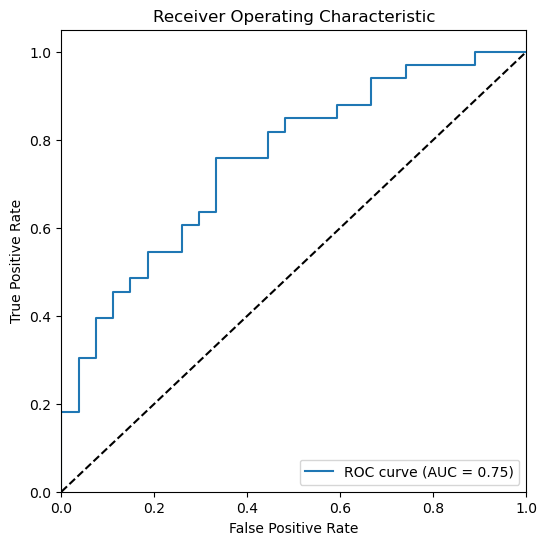

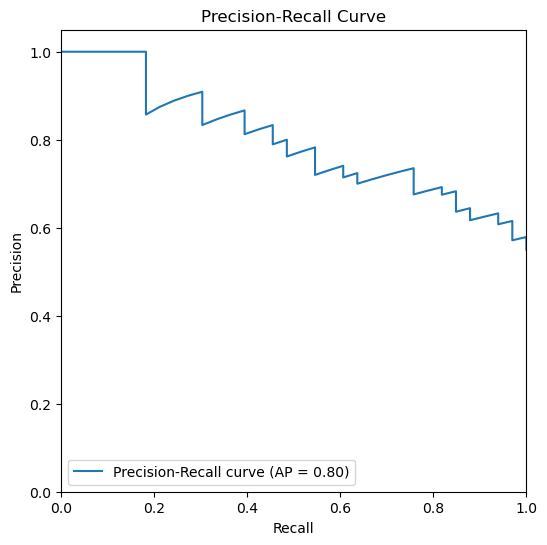

In [9]:
# Make predictions
y_pred = best_model.predict(X_test_final)
y_pred_proba = best_model.predict_proba(X_test_final)[:, 1]  # Probabilities for class 1

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\nFinal Model Evaluation on Test Set:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Best Binary Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)
plt.figure(figsize=(6,6))
plt.plot(recall_curve, precision_curve, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()